In [1]:
import os
import time
import math
import itertools
import yaml
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds

In [2]:
def set_seed(seed=702):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(702)

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

class Hypernet_trans(nn.Module):
    def __init__(self, ray_hidden_dim=32, out_dim=2, target_hidden_dim=15, n_hidden=1, n_tasks=2):
        super().__init__()
        self.n_hidden = n_hidden
        self.n_tasks = n_tasks

        # Các layer giữ nguyên
        if self.n_tasks == 2:
            self.embedding_layer1 = nn.Sequential(nn.Linear(1, ray_hidden_dim), nn.ReLU(inplace=True))
            self.embedding_layer2 = nn.Sequential(nn.Linear(1, ray_hidden_dim), nn.ReLU(inplace=True))
        else:
            self.embedding_layer1 = nn.Sequential(nn.Linear(1, ray_hidden_dim), nn.ReLU(inplace=True))
            self.embedding_layer2 = nn.Sequential(nn.Linear(1, ray_hidden_dim), nn.ReLU(inplace=True))
            self.embedding_layer3 = nn.Sequential(nn.Linear(1, ray_hidden_dim), nn.ReLU(inplace=True))
            
        self.output_layer = nn.Linear(ray_hidden_dim, out_dim)
        self.attention = nn.MultiheadAttention(embed_dim=ray_hidden_dim, num_heads=2)
        self.ffn1 = nn.Linear(ray_hidden_dim, ray_hidden_dim)
        self.ffn2 = nn.Linear(ray_hidden_dim, ray_hidden_dim)

    def forward(self, ray):
        """
        Input ray: (Batch_Size, n_tasks) -> VD: (20, 2)
        Output x: (Batch_Size, out_dim) -> VD: (20, 2)
        """
        
        if self.n_tasks == 2: 
            emb1 = self.embedding_layer1(ray[:, 0].unsqueeze(1)) 
            emb2 = self.embedding_layer2(ray[:, 1].unsqueeze(1))
            
            x = torch.stack((emb1, emb2), dim=0) 
        else:
            x = torch.stack(
                (
                    self.embedding_layer1(ray[:, 0].unsqueeze(1)),
                    self.embedding_layer2(ray[:, 1].unsqueeze(1)),
                    self.embedding_layer3(ray[:, 2].unsqueeze(1))
                ), dim=0
            )
        
        # --- Transformer Block (Seq_len, Batch, Dim) ---
        x_res = x
        x, _ = self.attention(x, x, x)
        x = x + x_res
        
        x_res = x
        x = self.ffn1(x)
        x = F.relu(x)
        x = self.ffn2(x)
        x = x + x_res
        
        # --- Output Layer ---
        # x: (Seq_len, Batch, Hidden) -> (Seq_len, Batch, Out_dim)
        x = self.output_layer(x)
        
        # --- Aggregation ---
        # Kết quả: (Batch, Out_dim)
        x = torch.mean(x, dim=0) 
        
        
        return x

# Const

In [4]:
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [5]:
GROUND_TRUTH_FILE = "../4_Pareto_front/test/ex4/pf_dynamic_true.npy" 

if os.path.exists(GROUND_TRUTH_FILE):
    pf_true = np.load(GROUND_TRUTH_FILE)
    print(f"✅ Đã tải ground truth Pareto front từ: {GROUND_TRUTH_FILE}, Shape: {pf_true.shape}")
else:
    print(f"❌ KHÔNG tìm thấy file ground truth tại: {GROUND_TRUTH_FILE}")

✅ Đã tải ground truth Pareto front từ: ../4_Pareto_front/test/ex4/pf_dynamic_true.npy, Shape: (20, 2)


# Def

In [6]:
import autograd.numpy as np
from scipy.optimize import minimize            
        
class Projection:
    def __init__(self, cons, bounds, dim, proj_type='euclid'):
        self.cons = cons
        self.bounds = bounds
        self.dim = dim
        self.proj_type = proj_type
        
        if self.proj_type == 'qplus':
            self.objective_func = self._obj_positive_diff
        elif self.proj_type == 'euclid':
            self.objective_func = self._obj_l2_norm
        else:
            print(f"Phép chiếu {self.objective_func} không cài đặt, chọn 'qplus' hoặc 'euclid'")

    def _obj_l2_norm(self, x, y):
        return np.sqrt(np.sum((x - y)**2))
    
    def _obj_positive_diff(self, x, y):
        v = np.maximum(y - x, 0) 
        return np.sum(v**2)

    def project(self, target_point):
        init_point = np.random.rand(1, self.dim).tolist()[0]
        
        res = minimize(
            self.objective_func,
            init_point,
            args=(target_point, ),
            constraints=self.cons,
            bounds=self.bounds,
            options={'disp': False}
        )
        
        optim_point = res.x
        
        if self.proj_type == 'qplus':
            return target_point - np.maximum(target_point - optim_point, 0)
        else:
            return optim_point

class Problem():
    def __init__(self, f, dim_x, dim_y, proj_C, proj_Qplus):
        self.f = f
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.proj_C = proj_C
        self.proj_Qplus = proj_Qplus
    
    def objective_func(self, x):
        vals = [func(x) for func in self.f]
        return np.concatenate(vals)  

In [7]:
def f1(x): return 4*x[0]**2 + 4*x[1]**2
def f2(x): return (x[0] - 5)**2 + (x[1] - 5)**2

def c1(x): return -(x[0] - 5)**2 - x[1]**2 + 25
def c2(x): return -(x[0] - 8)**2 - (x[1] + 3)**2 + 17.7

def q1(y): return 50**2 - (y[0] - 50)**2 - (y[1] - 50)**2
def q_plus(y):
    center = 50.0; radius_sq = 50**2
    dx = np.maximum(0, y[0] - center)
    dy = np.maximum(0, y[1] - center)
    return radius_sq - (dx**2 + dy**2)

cons_C = ({'type': 'ineq', 'fun': c1}, {'type': 'ineq', 'fun': c2})
cons_Q = ({'type': 'ineq', 'fun': q1},)
cons_Qplus = ({'type': 'ineq', 'fun': q_plus},)
bounds_x = Bounds([-15,-15],[30, 30])
dim_x = 2; dim_y = 2

# Setup
proj_C_handler = Projection(cons_C, bounds_x, dim_x, 'euclid')
proj_Q_handler = Projection(cons_Q, None, dim_y, 'qplus')
prob = Problem([f1, f2], dim_x, dim_y, proj_C_handler.project, proj_Q_handler.project)
z_star = np.array([75.23366646094793, 25.502227623508944]) 

In [8]:
def evaluate_objectives_single(functions, x_tensor):
    vals = []
    for func in functions:
        val = func(x_tensor)
        if not torch.is_tensor(val): val = torch.tensor(val, dtype=torch.float32, device=x_tensor.device)
        vals.append(val)
    return torch.stack(vals).reshape(-1)

def calculate_mse_igd(pf_pred, pf_true):
    if len(pf_pred) == 0: return np.inf
    total_dist_sq = 0
    # Với mỗi điểm ground truth, tìm điểm dự đoán gần nhất
    for p_true in pf_true:
        dists_sq = np.sum((pf_pred - p_true)**2, axis=1)
        total_dist_sq += np.min(dists_sq)
    return total_dist_sq / len(pf_true)

In [9]:
def train_hypernet(hypernet, prob, z_star, 
                   num_epochs=1000, lr=1e-3, num_partitions=50, 
                   lr_step_size=300, lr_gamma=0.5,
                   init_pen_C=1.0, max_pen_C=1000.0, pen_C_growth=1.01,
                   init_pen_Q=50.0, min_pen_Q=1.0, pen_Q_decay=0.995,
                   verbose=False):
    
    hypernet = hypernet.to(device)
    optimizer = optim.Adam(hypernet.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)
    z_star_tensor = torch.tensor(z_star, dtype=torch.float32, device=device).view(1, -1)
    
    current_pen_C = init_pen_C
    current_pen_Q = init_pen_Q
    angle_step = (math.pi / 2) / num_partitions
    
    for epoch in range(num_epochs):
        hypernet.train()
        optimizer.zero_grad()
        
        # 1. Stratified Sampling
        starts = torch.arange(num_partitions) * angle_step
        noise = torch.rand(num_partitions) * angle_step
        thetas = starts + noise
        r_batch_np = np.stack([np.cos(thetas.numpy()), np.sin(thetas.numpy())], axis=1)
        r_tensor_batch = torch.tensor(r_batch_np, dtype=torch.float32, device=device)
        
        # 2. Forward & Loss Calculation (Loop safe logic)
        loss_C_list = []
        loss_Q_list = []
        y_pred_list = []
        
        # Forward pass batch (Nhanh hơn gọi từng cái)
        x_vec_batch = hypernet(r_tensor_batch) # (Batch, 2)
        x_np_batch = x_vec_batch.detach().cpu().numpy()
        
        for i in range(num_partitions):
            x_i_tensor = x_vec_batch[i]
            x_i_np = x_np_batch[i]
            
            # Loss C
            x_proj_i_np = prob.proj_C(x_i_np)
            x_proj_i_tensor = torch.tensor(x_proj_i_np, dtype=torch.float32, device=device)
            loss_C_list.append(torch.sum((x_i_tensor - x_proj_i_tensor)**2))
            
            # F(x)
            y_pred_i = evaluate_objectives_single(prob.f, x_i_tensor)
            y_pred_list.append(y_pred_i)
            
            # Loss Q
            y_i_np = y_pred_i.detach().cpu().numpy()
            y_proj_i_np = prob.proj_Qplus(y_i_np)
            y_proj_i_tensor = torch.tensor(y_proj_i_np, dtype=torch.float32, device=device)
            loss_Q_list.append(torch.sum((y_pred_i - y_proj_i_tensor)**2))
            
        y_pred_batch = torch.stack(y_pred_list)
        loss_C = torch.mean(torch.stack(loss_C_list))
        loss_Q = torch.mean(torch.stack(loss_Q_list))
        
        # Chebyshev Loss
        diff = y_pred_batch - z_star_tensor
        weighted_diff = r_tensor_batch * diff
        max_vals, _ = torch.max(weighted_diff, dim=1)
        loss_obj = torch.mean(max_vals)
        
        total_loss = loss_obj + (current_pen_C * loss_C) + (current_pen_Q * loss_Q)
        
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Update Penalties
        current_pen_C = min(max_pen_C, current_pen_C * pen_C_growth)
        current_pen_Q = max(min_pen_Q, current_pen_Q * pen_Q_decay)
        
        if verbose and epoch % (num_epochs // 5) == 0:
            print(f"  Ep {epoch}: Loss={total_loss.item():.2f} (Obj={loss_obj.item():.2f}, C={loss_C.item():.4f})")
            
    return hypernet

In [10]:
def evaluate_model(hypernet, prob, test_rays, pf_true):
    hypernet.eval()
    pf_pred = []
    
    # Chuyển test_rays sang tensor batch để infer nhanh
    rays_tensor = torch.tensor(test_rays, dtype=torch.float32, device=device)
    
    with torch.no_grad():
        x_raw = hypernet(rays_tensor) # (N, 2)
        x_raw_np = x_raw.cpu().numpy()
        
        # Loop project and eval
        for i in range(len(x_raw_np)):
            # Chiếu lên C (Quan trọng để feasible)
            x_proj = prob.proj_C(x_raw_np[i])
            # Tính f
            val = [func(x_proj) for func in prob.f]
            pf_pred.append(val)
            
    pf_pred = np.array(pf_pred)
    igd_score = calculate_mse_igd(pf_pred, pf_true)
    return igd_score, pf_pred

# Config

In [11]:
param_grid = {
    'lr': [1e-3],
    'num_epochs': [1000],
    'pen_C_growth': [1.005, 1.01, 1.05],      # Tăng phạt C nhanh hay chậm
    'pen_Q_decay': [0.995],      
    'init_pen_C': [10.0, 50.0, 100.0],
    'init_pen_Q': [20.0, 50.0],
    'max_pen_C': [500.0, 1000.0, 2000.0]
}

config_path='../4_Pareto_front/config.yaml'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
test_rays = np.array(cfg['data']['test_ray'])

# Run

In [12]:
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"🔍 Bắt đầu Grid Search với {len(param_combinations)} cấu hình...")

results = []
best_igd = float('inf')
best_config = None
best_pf_pred = None

# --- Main Tuning Loop ---
for idx, params in enumerate(param_combinations):
    print(f"\n--- Running Config {idx+1}/{len(param_combinations)} ---")
    print(params)
    
    # 1. Init Model
    model = Hypernet_trans(ray_hidden_dim=32, out_dim=dim_x, n_tasks=2)
    
    # 2. Train
    start_time = time.time()
    trained_model = train_hypernet(
        model, prob, z_star, 
        num_epochs=params['num_epochs'],
        lr=params['lr'],
        num_partitions=20, 
        init_pen_C=params['init_pen_C'],
        pen_C_growth=params['pen_C_growth'],
        init_pen_Q=params['init_pen_Q'],
        pen_Q_decay=params['pen_Q_decay'],
        verbose=True
    )
    train_time = time.time() - start_time
    
    # 3. Evaluate
    igd, pf_pred = evaluate_model(trained_model, prob, test_rays, pf_true)
    
    print(f"⏱️ Time: {train_time:.2f}s | 📉 IGD Score: {igd:.4f}")
    
    # Save result
    res = {
        'config_id': idx,
        'params': params,
        'igd': igd,
        'time': train_time
    }
    results.append(res)
    
    # Update Best
    if igd < best_igd:
        best_igd = igd
        best_config = params
        best_pf_pred = pf_pred
        # Lưu model tốt nhất (optional)
        torch.save(trained_model.state_dict(), "best_hypernet_trans_tuned.pth")



🔍 Bắt đầu Grid Search với 54 cấu hình...

--- Running Config 1/54 ---
{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growth': 1.005, 'pen_Q_decay': 0.995, 'init_pen_C': 10.0, 'init_pen_Q': 20.0, 'max_pen_C': 500.0}
  Ep 0: Loss=186.18 (Obj=14.40, C=17.1778)
  Ep 200: Loss=3.66 (Obj=2.59, C=0.0396)
  Ep 400: Loss=4.06 (Obj=3.34, C=0.0097)
  Ep 600: Loss=3.85 (Obj=3.53, C=0.0016)
  Ep 800: Loss=3.86 (Obj=3.68, C=0.0003)
⏱️ Time: 81.14s | 📉 IGD Score: 4.3152

--- Running Config 2/54 ---
{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growth': 1.005, 'pen_Q_decay': 0.995, 'init_pen_C': 10.0, 'init_pen_Q': 20.0, 'max_pen_C': 1000.0}
  Ep 0: Loss=191.64 (Obj=17.98, C=17.3664)
  Ep 200: Loss=3.19 (Obj=2.39, C=0.0297)
  Ep 400: Loss=3.50 (Obj=3.15, C=0.0047)
  Ep 600: Loss=3.64 (Obj=3.45, C=0.0010)
  Ep 800: Loss=3.81 (Obj=3.65, C=0.0003)
⏱️ Time: 81.60s | 📉 IGD Score: 4.0215

--- Running Config 3/54 ---
{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growth': 1.005, 'pen_Q_decay': 0.995, 'init_pen_C': 10.0, 'ini

  Ep 400: Loss=4.38 (Obj=4.13, C=0.0005)
  Ep 600: Loss=3.90 (Obj=3.83, C=0.0001)
  Ep 800: Loss=3.87 (Obj=3.78, C=0.0001)
⏱️ Time: 86.69s | 📉 IGD Score: 3.5656

--- Running Config 21/54 ---
{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growth': 1.01, 'pen_Q_decay': 0.995, 'init_pen_C': 10.0, 'init_pen_Q': 20.0, 'max_pen_C': 2000.0}
  Ep 0: Loss=225.99 (Obj=15.39, C=21.0599)
  Ep 200: Loss=3.52 (Obj=3.15, C=0.0050)
  Ep 400: Loss=3.81 (Obj=3.63, C=0.0003)
  Ep 600: Loss=3.76 (Obj=3.68, C=0.0001)
  Ep 800: Loss=3.81 (Obj=3.74, C=0.0001)
⏱️ Time: 86.67s | 📉 IGD Score: 3.5650

--- Running Config 22/54 ---
{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growth': 1.01, 'pen_Q_decay': 0.995, 'init_pen_C': 10.0, 'init_pen_Q': 50.0, 'max_pen_C': 500.0}
  Ep 0: Loss=156.43 (Obj=13.87, C=14.2558)
  Ep 200: Loss=4.38 (Obj=3.58, C=0.0110)
  Ep 400: Loss=3.87 (Obj=3.79, C=0.0002)
  Ep 600: Loss=3.86 (Obj=3.77, C=0.0001)
  Ep 800: Loss=3.83 (Obj=3.77, C=0.0001)
⏱️ Time: 88.30s | 📉 IGD Score: 5.2272

--- Running

  Ep 200: Loss=6.68 (Obj=6.60, C=0.0001)
  Ep 400: Loss=4.86 (Obj=4.73, C=0.0001)
  Ep 600: Loss=4.57 (Obj=4.46, C=0.0001)
  Ep 800: Loss=4.59 (Obj=4.37, C=0.0002)
⏱️ Time: 100.24s | 📉 IGD Score: 10.9955

--- Running Config 41/54 ---
{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growth': 1.05, 'pen_Q_decay': 0.995, 'init_pen_C': 10.0, 'init_pen_Q': 50.0, 'max_pen_C': 1000.0}
  Ep 0: Loss=239.73 (Obj=18.17, C=22.1560)
  Ep 200: Loss=10.15 (Obj=10.13, C=0.0000)
  Ep 400: Loss=7.08 (Obj=6.92, C=0.0002)
  Ep 600: Loss=6.38 (Obj=6.24, C=0.0001)
  Ep 800: Loss=6.14 (Obj=5.97, C=0.0002)
⏱️ Time: 108.34s | 📉 IGD Score: 37.2815

--- Running Config 42/54 ---
{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growth': 1.05, 'pen_Q_decay': 0.995, 'init_pen_C': 10.0, 'init_pen_Q': 50.0, 'max_pen_C': 2000.0}
  Ep 0: Loss=235.71 (Obj=17.45, C=21.8262)
  Ep 200: Loss=15.69 (Obj=15.65, C=0.0000)
  Ep 400: Loss=11.04 (Obj=11.03, C=0.0000)
  Ep 600: Loss=4.99 (Obj=4.74, C=0.0002)
  Ep 800: Loss=4.57 (Obj=4.38, C=0.0002

# Viz


🏆 BEST CONFIGURATION FOUND (IGD=3.1932)
lr: 0.001
num_epochs: 1000
pen_C_growth: 1.005
pen_Q_decay: 0.995
init_pen_C: 10.0
init_pen_Q: 50.0
max_pen_C: 2000.0

Top 5 Configs:
Rank 1: IGD=3.1932 | Params={'lr': 0.001, 'num_epochs': 1000, 'pen_C_growth': 1.005, 'pen_Q_decay': 0.995, 'init_pen_C': 10.0, 'init_pen_Q': 50.0, 'max_pen_C': 2000.0}
Rank 2: IGD=3.5650 | Params={'lr': 0.001, 'num_epochs': 1000, 'pen_C_growth': 1.01, 'pen_Q_decay': 0.995, 'init_pen_C': 10.0, 'init_pen_Q': 20.0, 'max_pen_C': 2000.0}
Rank 3: IGD=3.5656 | Params={'lr': 0.001, 'num_epochs': 1000, 'pen_C_growth': 1.01, 'pen_Q_decay': 0.995, 'init_pen_C': 10.0, 'init_pen_Q': 20.0, 'max_pen_C': 1000.0}
Rank 4: IGD=3.8748 | Params={'lr': 0.001, 'num_epochs': 1000, 'pen_C_growth': 1.01, 'pen_Q_decay': 0.995, 'init_pen_C': 100.0, 'init_pen_Q': 50.0, 'max_pen_C': 1000.0}
Rank 5: IGD=3.9175 | Params={'lr': 0.001, 'num_epochs': 1000, 'pen_C_growth': 1.05, 'pen_Q_decay': 0.995, 'init_pen_C': 50.0, 'init_pen_Q': 20.0, 'max_pen_

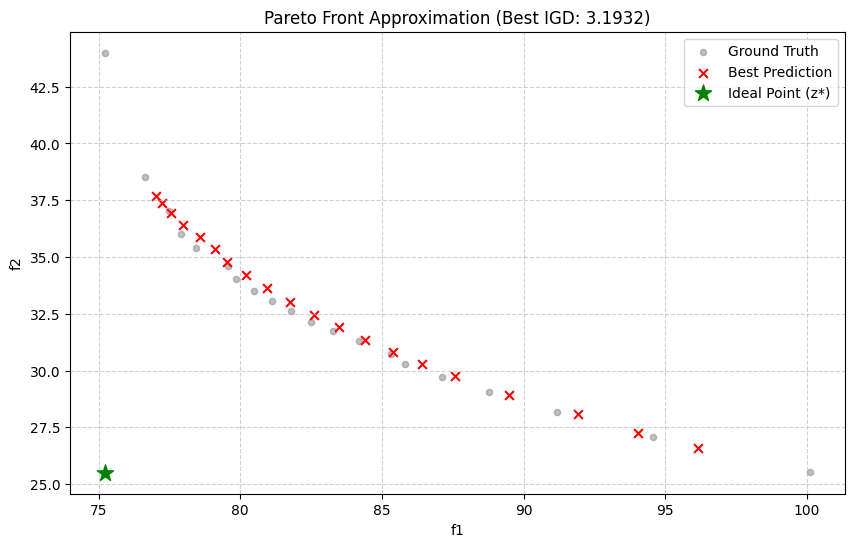

In [13]:
print("\n" + "="*40)
print(f"🏆 BEST CONFIGURATION FOUND (IGD={best_igd:.4f})")
print("="*40)
for k, v in best_config.items():
    print(f"{k}: {v}")

# Sắp xếp kết quả theo IGD
sorted_results = sorted(results, key=lambda x: x['igd'])
print("\nTop 5 Configs:")
for i in range(min(5, len(sorted_results))):
    r = sorted_results[i]
    print(f"Rank {i+1}: IGD={r['igd']:.4f} | Params={r['params']}")

# --- Plotting ---
plt.figure(figsize=(10, 6))

# Plot Ground Truth
if pf_true is not None:
    plt.scatter(pf_true[:, 0], pf_true[:, 1], c='gray', alpha=0.5, label='Ground Truth', s=20)

# Plot Best Prediction
if best_pf_pred is not None:
    plt.scatter(best_pf_pred[:, 0], best_pf_pred[:, 1], c='red', marker='x', label='Best Prediction', s=40)

# Plot Ideal Point
plt.scatter(z_star[0], z_star[1], c='green', marker='*', s=150, label='Ideal Point (z*)')

plt.xlabel('f1')
plt.ylabel('f2')
plt.title(f'Pareto Front Approximation (Best IGD: {best_igd:.4f})')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [14]:
import pandas as pd

pd.DataFrame(sorted_results)

,config_id,params,igd,time
0,5,"{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growt...",3.193151,79.239307
1,20,"{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growt...",3.565047,86.667707
2,19,"{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growt...",3.565648,86.686694
3,34,"{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growt...",3.874790,103.620129
4,43,"{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growt...",3.917462,98.314711
5,29,"{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growt...",4.008742,90.061170
6,1,"{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growt...",4.021538,81.596900
7,36,"{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growt...",4.056732,93.763810
8,16,"{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growt...",4.135219,97.725530
9,12,"{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growt...",4.155141,108.391381
